In [5]:
!pip install matplotlib
%pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 2.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [7]:


# %pip install ipympl
## avec Max et Min

%matplotlib widget
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the constituents
constituents = [
    ('M2', 1, 1, 28.984104),
    ('S2', 1, 1, 30.0),
    ('N2', 1, 1, 28.43973),
    ('K1', 1, 1, 15.041069),
    ('O1', 1, 1, 13.943035),
    ('P1', 1, 1, 14.958931),
    ('M4', 1, 1, 57.96821)
]

# Load the tide data from CSV
csv_file_path = '0101-3112-2023(m).csv'
tide_data = pd.read_csv(csv_file_path)

# Combine date and time into one datetime column (if necessary) and convert to seconds since epoch
epoch = datetime(1983, 1, 1)
tide_data['Datetime'] = pd.to_datetime(tide_data['Date'] + ' ' + tide_data['Time (GMT)'])
tide_data['Seconds since epoch'] = (tide_data['Datetime'] - epoch).dt.total_seconds()

# Extract observed heights and times
observed_heights = tide_data['Verified (m)'].values
times = tide_data['Seconds since epoch'].values

# Convert amplitudes from feet to meters and phases from degrees to radians
amplitudes = np.array([amp for _, amp, _, _ in constituents]) * 0.3048
phases = np.array([phase for _, _, phase, _ in constituents]) * np.pi / 180
speeds = np.array([speed for _, _, _, speed in constituents]) * np.pi / 180 / 3600

# Prediction function
def predict_tide(times, amplitudes, phases, speeds):
    tide_height = np.sum(amplitudes * np.cos(speeds * times[:, None] + phases), axis=1)
    return tide_height

# Loss function
def loss_fn(params, times, observed_heights):
    num_constituents = len(speeds)
    amplitudes = params[:num_constituents]
    phases = params[num_constituents:]
    predictions = predict_tide(times, amplitudes, phases, speeds)
    return np.mean((predictions - observed_heights) ** 2)

# Initial parameters
initial_params = np.concatenate([amplitudes, phases])

# Marquer le début de l'optimisation
start_time = datetime.now()

# Run the optimizer
res = minimize(
    fun=loss_fn,
    x0=initial_params,
    args=(times, observed_heights),
    method='L-BFGS-B',
    options={'maxfun': 50000, 'maxiter': 50000}
)

# Marquer la fin de l'optimisation
end_time = datetime.now()

# Calculer la durée
duration = end_time - start_time

if res.success:
    optimized_params = res.x
    optimized_amplitudes = optimized_params[:len(speeds)]
    optimized_phases = optimized_params[len(speeds):]
    print("Optimization successful.")
    print(f"Optimization time: {duration}")

    # Affichage des constituants optimisés
    print("Optimized Constituents:")
    for i, constituent in enumerate(constituents):
        name = constituent[0]
        print(f"{name}: Amplitude (meters) = {optimized_amplitudes[i]:.4f}, Phase (degrees) = {optimized_phases[i]:.4f}")
else:
    print("Optimization failed.")
    print(f"Optimization failed with message: {res.message}")

# Load the new NOAA data
noaa_data_path = '01-02-2024.csv'
noaa_data = pd.read_csv(noaa_data_path)
noaa_data['Datetime'] = pd.to_datetime(noaa_data['Date'] + ' ' + noaa_data['Time (GMT)'])
noaa_timestamps = noaa_data['Datetime'].apply(lambda x: x.timestamp()).values
noaa_verified_heights = noaa_data['Verified (m)'].values

# Generate timestamps for predictions
start_datetime = datetime(2024, 2, 1)
timestamps = np.array([(start_datetime + timedelta(hours=i)).timestamp() for i in range(24)])
times_since_epoch = (timestamps - epoch.timestamp())

# Predict tide heights for these times using initial and optimized parameters
predicted_initial = predict_tide(times_since_epoch, amplitudes, phases, speeds)
predicted_optimized = predict_tide(times_since_epoch, optimized_amplitudes, optimized_phases, speeds)

# Erreur quadratique
def calculate_rmse(observed, predicted):
    return np.sqrt(mean_squared_error(observed, predicted))

rmse = calculate_rmse(noaa_verified_heights, predicted_optimized)
print(f"RMSE: {rmse}")

# MAX and MIN
def find_high_low_tides(times, predicted_heights):
    high_tides = []
    low_tides = []
    for i in range(1, len(predicted_heights) - 1):
        if predicted_heights[i] > predicted_heights[i - 1] and predicted_heights[i] > predicted_heights[i + 1]:
            high_tides.append((times[i], predicted_heights[i]))
        elif predicted_heights[i] < predicted_heights[i - 1] and predicted_heights[i] < predicted_heights[i + 1]:
            low_tides.append((times[i], predicted_heights[i]))
    return high_tides, low_tides

# Find high and low tides
high_tides, low_tides = find_high_low_tides(timestamps, predicted_optimized)

# Print high and low tides
print("\nHigh Tides in the next 24 hours:")
for tide in high_tides:
    print(f"{datetime.fromtimestamp(tide[0]).strftime('%Y-%m-%d %H:%M:%S')}: Height {tide[1]:.2f} meters")

print("\nLow Tides in the next 24 hours:")
for tide in low_tides:
    print(f"{datetime.fromtimestamp(tide[0]).strftime('%Y-%m-%d %H:%M:%S')}: Height {tide[1]:.2f} meters")

print('Optimized amplitude ' )

plt.figure(figsize=(12, 6))
plt.plot(timestamps, predicted_initial, label='Initial Prediction', marker='o')
plt.plot(timestamps, predicted_optimized, label='Optimized Prediction', marker='x')
plt.plot(noaa_timestamps, noaa_verified_heights, label='NOAA Verified (New Data)', marker='s', linestyle='--', color='red')
plt.xlabel('Hour of the Day on 10/01/2024')
plt.ylabel('Tide Height (meters)')
plt.title('24-Hour Tide Height Prediction Before and After Optimization with New NOAA Verified Data')
plt.xticks(timestamps, [f"{i}:00" for i in range(24)], rotation=45)
plt.legend()
plt.tight_layout() # Adjust layout to prevent clipping of tick labels
plt.show()

Optimization successful.
Optimization time: 0:00:02.108396
Optimized Constituents:
M2: Amplitude (meters) = -0.5300, Phase (degrees) = -0.8788
S2: Amplitude (meters) = -0.1391, Phase (degrees) = -0.2944
N2: Amplitude (meters) = -0.1191, Phase (degrees) = -0.5393
K1: Amplitude (meters) = -0.4171, Phase (degrees) = -0.5929
O1: Amplitude (meters) = -0.2693, Phase (degrees) = -1.1925
P1: Amplitude (meters) = -0.1192, Phase (degrees) = -0.8007
M4: Amplitude (meters) = 0.0009, Phase (degrees) = 0.0178


FileNotFoundError: [Errno 2] No such file or directory: '01-02-2024.csv'

Le Mean Sea Level (MSL) calculé pour l'année 2023 est de : 2.480077643297556 mètres
Optimization successful.
Optimization time: 0:00:06.041307
RMSE for the entire month: 0.30989268447028073


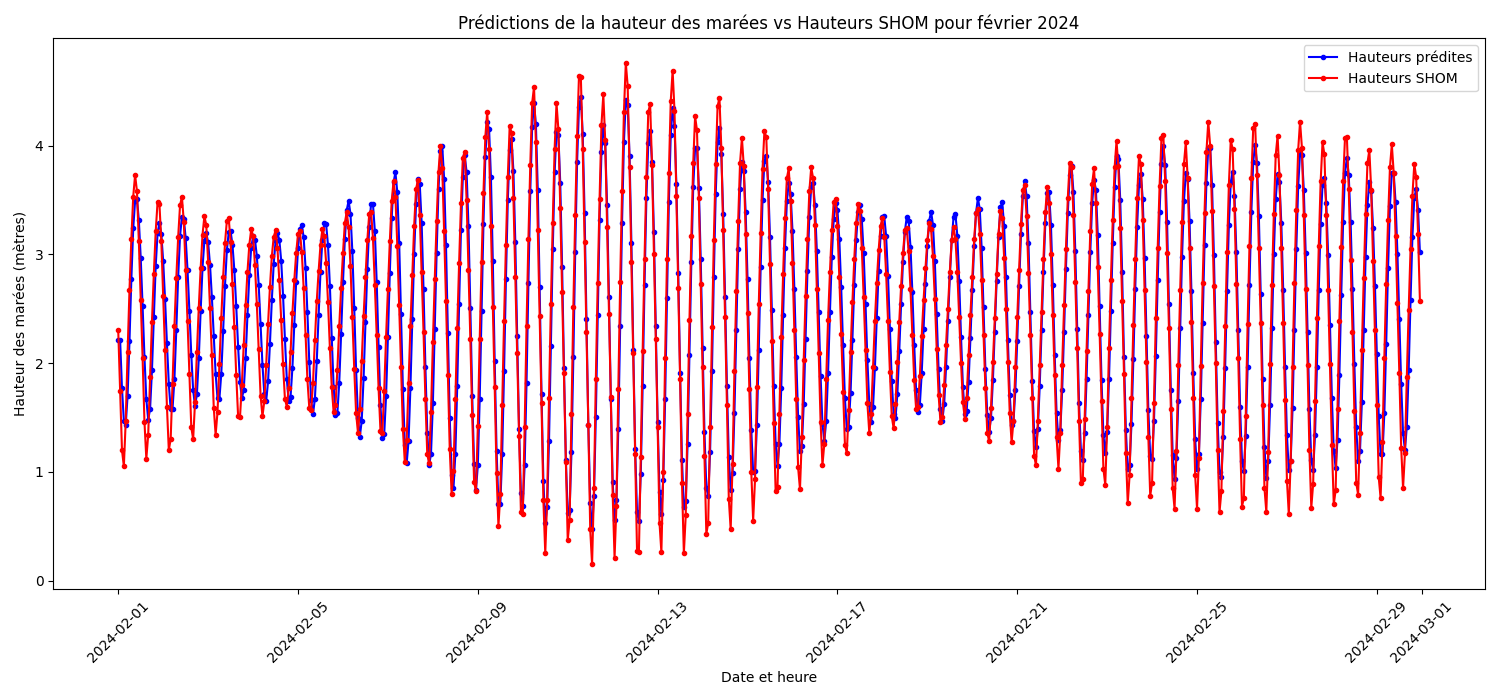

In [10]:
### Pour tout le mois

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the constituents
constituents = [
    ('M2', 0, 0, 28.984104),
    ('S2', 0, 0, 30.0),
    ('N2', 0, 0, 28.43973),
    ('K1', 0, 0, 15.041069),
    ('O1', 0, 0, 13.943035),
    ('P1', 0, 0, 14.958931),
    ('M4', 0, 0, 57.96821)
]

# Load the tide data from CSV
csv_file_path = 'donnees_marees_2020_2023_cleaned.csv'
tide_data = pd.read_csv(csv_file_path)

# Calculer le Mean Sea Level (MSL) à partir des données de 2023
msl_2023 = tide_data['Verified (m)'].mean()
print(f"Le Mean Sea Level (MSL) calculé pour l'année 2023 est de : {msl_2023} mètres")


# Combine date and time into one datetime column (if necessary) and convert to seconds since epoch
epoch = datetime(1983, 1, 1)
tide_data['Datetime'] = pd.to_datetime(tide_data['Date'] + ' ' + tide_data['Time (GMT)'])
tide_data['Seconds since epoch'] = (tide_data['Datetime'] - epoch).dt.total_seconds()

# Extract observed heights and times
observed_heights = tide_data['Verified (m)'].values
times = tide_data['Seconds since epoch'].values

# Convert amplitudes from feet to meters and phases from degrees to radians
amplitudes = np.array([amp for _, amp, _, _ in constituents]) * 0.3048
phases = np.array([phase for _, _, phase, _ in constituents]) * np.pi / 180
speeds = np.array([speed for _, _, _, speed in constituents]) * np.pi / 180 / 3600

# Prediction function
def predict_tide(times, amplitudes, phases, speeds):
    tide_height = np.sum(amplitudes * np.cos(speeds * times[:, None] + phases), axis=1)
    return  msl_2023 + tide_height

# Loss function
def loss_fn(params, times, observed_heights, speeds):
    num_constituents = len(speeds)
    amplitudes = params[:num_constituents]
    phases = params[num_constituents:]
    predictions = predict_tide(times, amplitudes, phases, speeds)
    return np.mean((predictions - observed_heights) ** 2)

# Initial parameters
initial_params = np.concatenate([amplitudes, phases])

# Marquer le début de l'optimisation
start_time = datetime.now()

# Run the optimizer
res = minimize(
    fun=loss_fn,
    x0=initial_params,
    args=(times, observed_heights, speeds),
    method='L-BFGS-B',
    options={'maxfun': 50000, 'maxiter': 50000}
)

# Marquer la fin de l'optimisation
end_time = datetime.now()

# Calculer la durée
duration = end_time - start_time

if res.success:
    optimized_params = res.x
    optimized_amplitudes = optimized_params[:len(speeds)]
    optimized_phases = optimized_params[len(speeds):]
    print("Optimization successful.")
    print(f"Optimization time: {duration}")
else:
    print("Optimization failed.")
    print(f"Optimization failed with message: {res.message}")

# Load the NOAA data for the entire month
noaa_data_path = 'ArcachonFevrier2024_cleaned.csv'
noaa_data = pd.read_csv(noaa_data_path)
noaa_data['Datetime'] = pd.to_datetime(noaa_data['Date'] + ' ' + noaa_data['Time (GMT)'])
noaa_seconds_since_epoch = (noaa_data['Datetime'] - epoch).dt.total_seconds().values
noaa_verified_heights = noaa_data['Verified (m)'].values

# Generate timestamps for predictions over the entire month

start_datetime = noaa_data['Datetime'].min()  # Start of NOAA data
end_datetime = noaa_data['Datetime'].max()    # End of NOAA data

total_hours = int((end_datetime - start_datetime).total_seconds() / 3600) + 1
timestamps = np.array([(start_datetime + timedelta(hours=i)).timestamp() for i in range(total_hours)])
times_since_epoch = (timestamps - epoch.timestamp())

# Predict tide heights for these times using optimized parameters
predicted_heights = predict_tide(times_since_epoch, optimized_amplitudes, optimized_phases, speeds)

# Calculate RMSE for the entire month
def calculate_rmse(observed, predicted):
    return np.sqrt(mean_squared_error(observed, predicted))

# Align predictions with NOAA verified heights
aligned_predicted_heights = np.interp(noaa_seconds_since_epoch, times_since_epoch, predicted_heights)
rmse = calculate_rmse(noaa_verified_heights, aligned_predicted_heights)
print(f"RMSE for the entire month: {rmse}")

# Plotting the results
plt.figure(figsize=(15, 7))
plt.plot(noaa_data['Datetime'], aligned_predicted_heights, label='Hauteurs prédites', marker='.', linestyle='-', color='blue')
plt.plot(noaa_data['Datetime'], noaa_data['Verified (m)'], label='Hauteurs SHOM', marker='.', linestyle='-', color='red')
plt.xlabel('Date et heure')
plt.ylabel('Hauteur des marées (mètres)')
plt.title('Prédictions de la hauteur des marées vs Hauteurs SHOM pour février 2024')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Ajuster la mise en page pour éviter le rognage des étiquettes

plt.show()